In [1]:
import pyspedas
import pytplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
#swe_vars = pyspedas.wind.swe(trange=['2003-11-20','2003-11-23'],datatype='h1',varnames=['BX','BY','BZ','Proton_Np_moment','Proton_W_moment'],downloadonly=True)

**Using CDFLIB**

In [8]:
import cdflib
cdf_file = cdflib.CDF(r'wget_download\wi_h1_swe_20031120_v01.cdf')

In [9]:
t_range= cdflib.cdfepoch.to_datetime(cdf_file.varget('epoch'))
t_range[:10]

array(['2003-11-20T00:01:12.248000', '2003-11-20T00:02:49.401000',
       '2003-11-20T00:04:26.554000', '2003-11-20T00:06:03.707000',
       '2003-11-20T00:07:40.861000', '2003-11-20T00:09:18.014000',
       '2003-11-20T00:10:55.167000', '2003-11-20T00:12:32.320000',
       '2003-11-20T00:14:09.473000', '2003-11-20T00:15:46.626000'],
      dtype='datetime64[us]')

**MATPLOTLIB**

**Deriving the Parameters**

In [10]:
 # Bmagnitude #nT is Ok
def bmagnitude(cdf_var : np.array) -> tuple:  
    X = cdf_var.varget('BX')
    Y = cdf_var.varget('BY')
    Z = cdf_var.varget('BZ')

    bmag = np.sqrt( X**2 + Y**2 + Z**2 )
    if bmag[bmag >= 1000]:
        bmag[bmag >= 1000] = np.nan
        bmag = pd.Series(bmag).interpolate().values


    return X,Y,Z,bmag



#Vp calculations
def Vp_vec(cdf_var : np.array) -> np.array:   #Vp calculations
    vX = cdf_var.varget('Proton_VX_moment')
    vY = cdf_var.varget('Proton_VY_moment')
    vZ = cdf_var.varget('Proton_VZ_moment')

    vp_vec = np.sqrt( vX**2 + vY**2 + vZ**2 )
    
    if vp_vec[vp_vec >= 1000]:
        vp_vec[vp_vec >= 1000] = np.nan
        vp_vec = pd.Series(vp_vec).interpolate().values


    return vp_vec



#Temp Calculations
def Temperature(cdf_var : np.array) -> np.array:   
    p_wpar = cdf_var.varget('Proton_W_moment')

    # p_wpar[p_wpar >= 99999] = np.nan
    # p_wpar_new = pd.Series(p_wpar).interpolate().values

    m_proton = 1.67e-27     # Mass of proton in kg
    k_boltzmann = 1.38e-23  # Boltzman constant
    vth_ms = p_wpar * 1000 # to make it m/s

    T = (m_proton * (vth_ms**2)) / (3 * k_boltzmann)

    return T



#plasma Beta calculations
def plasma_beta(n_p : np.array,Bmag: np.array ,T: np.array) -> np.array:  

    k_boltzmann = 1.380649e-23                      # Boltzmann constant 
    mu_0 = 4 * np.pi * 1e-7                         # Vacuum permeability in T m A^-1
    n_p = n_p * 1e6                                 # Proton number density in m^-3 (example value)
                                                    # Plasma temperature in Kelvin (example value)

    # Magnetic field strength in nanoTesla (example value)

    if Bmag[Bmag >= 1000]:
        Bmag[Bmag >= 1000] = np.nan
        Bmag = pd.Series(Bmag).interpolate().values

    B = Bmag * 1e-9            # Conversion from nanoTesla to Tesla

    # Calculate plasma beta
    p_beta = (n_p * k_boltzmann * T) / (B**2 / (2 * mu_0))

    return p_beta



#calculating angles ->
def angels(bx:np.array,by:np.array,bz:np.array,bmag:np.array):

    if bmag[bmag >= 1000]:
        bmag[bmag >= 1000] = np.nan
        bmag = pd.Series(bmag).interpolate().values

    angle_rad1 = np.arctan2(-by,-bx)        # arctan if need range 90
    angle_deg1 = np.degrees(angle_rad1)
    phi = angle_deg1 + 180

    angle_rad2 = np.arccos(-bz/bmag)
    angle_deg2 = np.degrees(angle_rad2)
    tetha = angle_deg2 - 90

    return tetha,phi


In [11]:
#plotting variables

BX,BY,BZ,b_mag = bmagnitude(cdf_file)


p_density = cdf_file.varget('Proton_Np_moment')
if p_density[p_density >= 10000]:
    p_density[p_density >= 10000] = np.nan
    p_density = pd.Series(p_density).interpolate().values

vp = Vp_vec(cdf_file)

temp = Temperature(cdf_file)


p_beta = plasma_beta(p_density,b_mag,temp)

tehta_angle,phi_angle = angels(BX,BY,BZ,b_mag)


11-Apr-24 13:59:03: C:\Users\KEVAL\AppData\Local\Temp\ipykernel_10076\1970889623.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bmag[bmag >= 1000]:

11-Apr-24 13:59:03: C:\Users\KEVAL\AppData\Local\Temp\ipykernel_10076\2297179079.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if p_density[p_density >= 10000]:

11-Apr-24 13:59:03: C:\Users\KEVAL\AppData\Local\Temp\ipykernel_10076\1970889623.py:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if vp_vec[vp_vec >= 1000]:

11-Apr-24 13:59:03: C:\Users\KEVAL\AppData\Local\Temp\ipykernel_10076\1970889623.py:

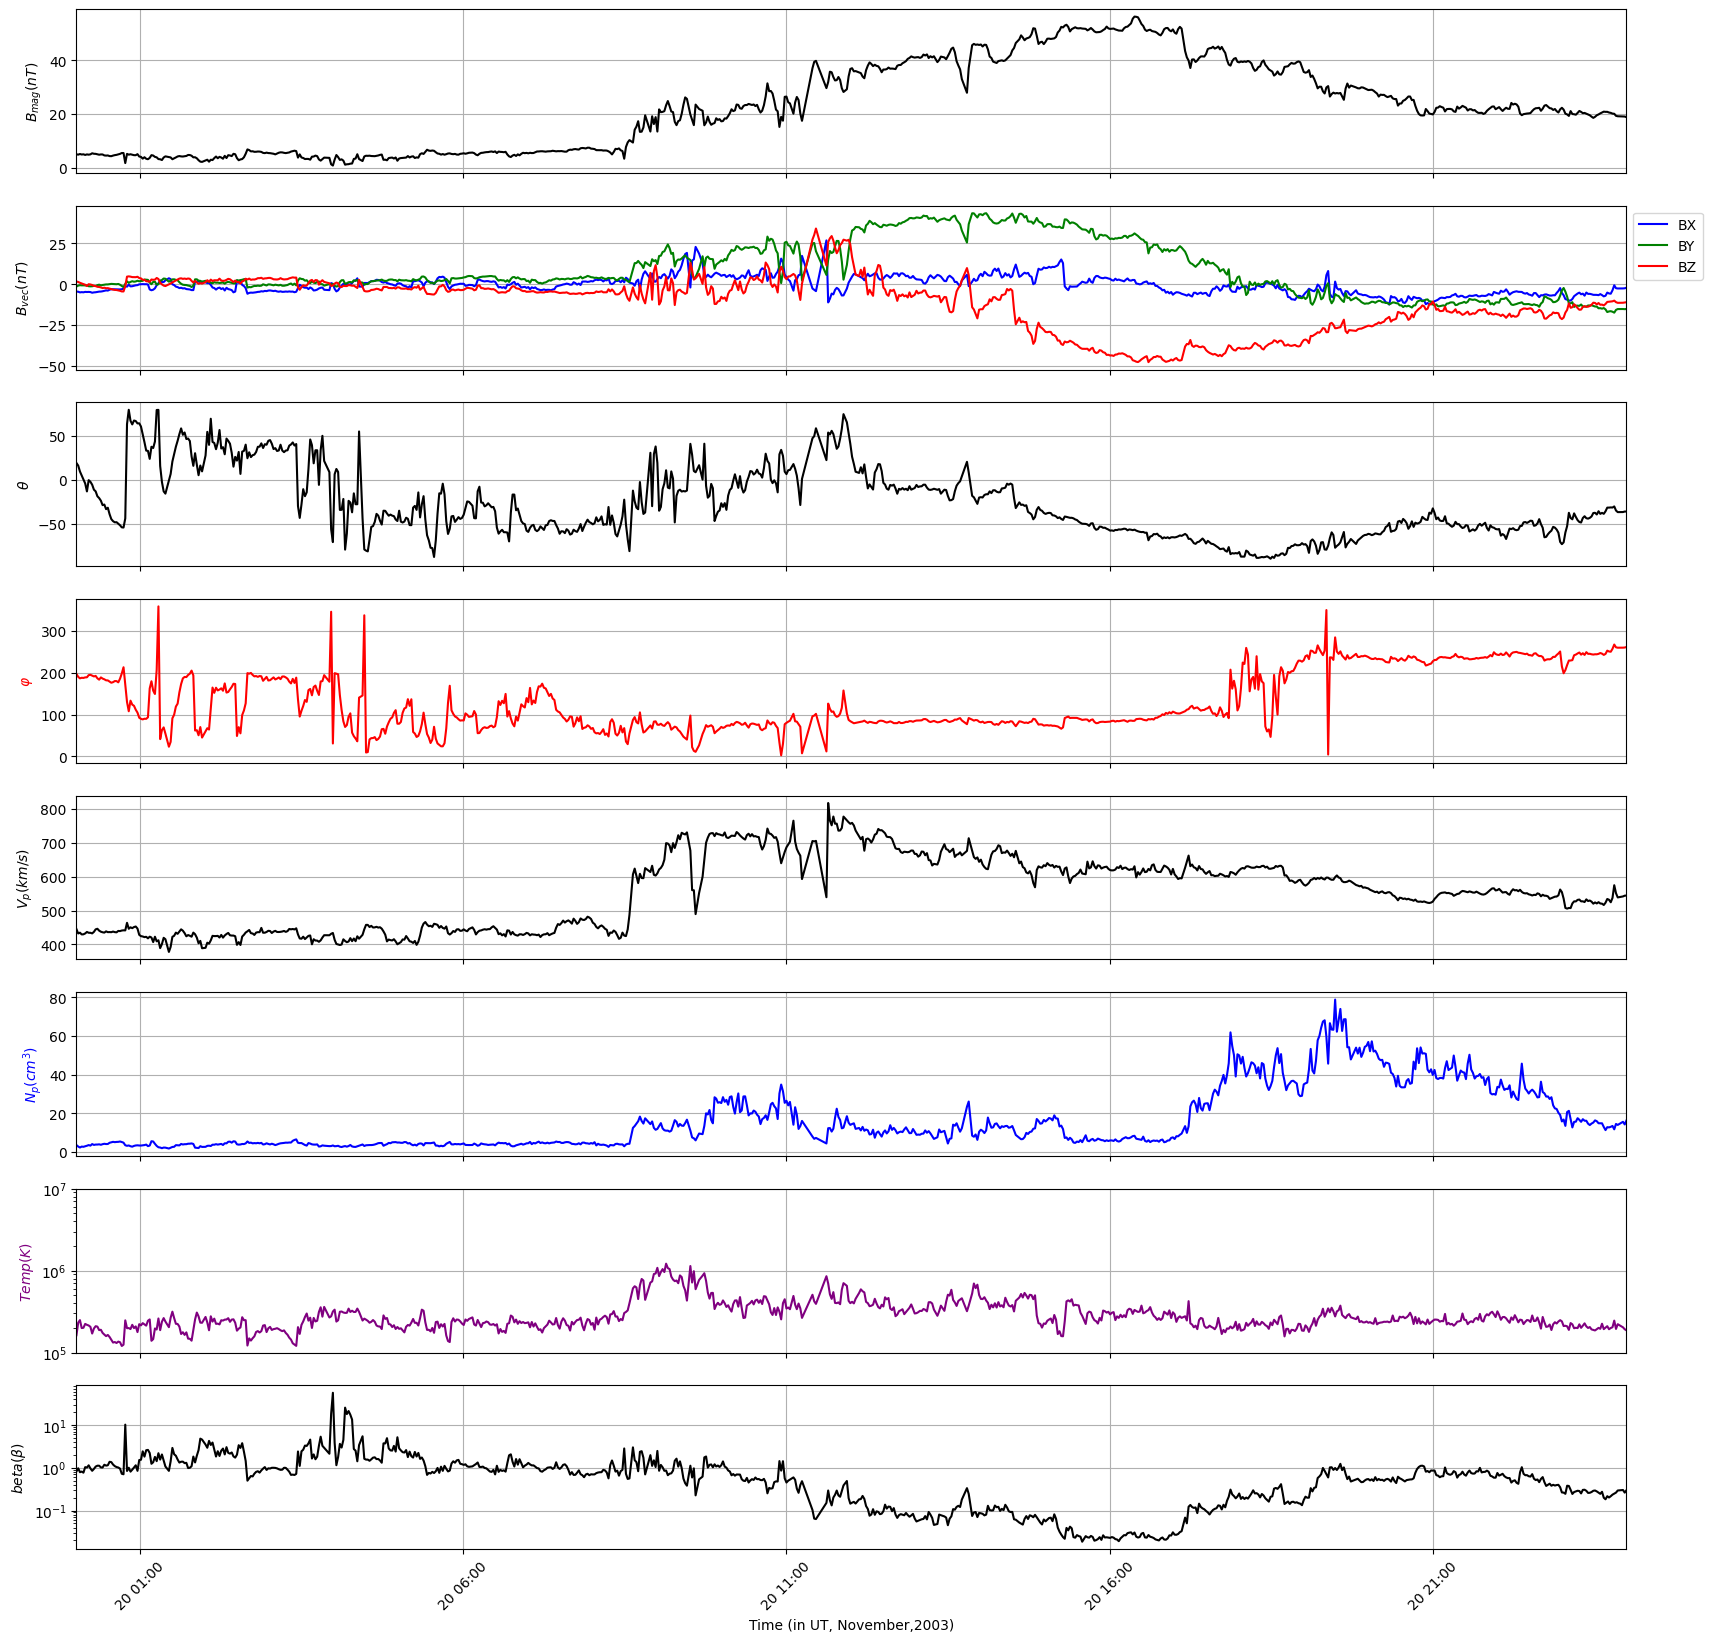

In [12]:
from modules.plotter import Plotting

plot  = Plotting()

plot.ipplot(t_range,b_mag,BX,BY,BZ,tehta_angle,phi_angle,vp,p_density,temp,p_beta)


# 3days-Plotting systen

In [ ]:
from datetime import datetime, timedelta


def read_files_in_date_range(start_date, end_date):
    date_format = "%d-%m-%Y"
    current_date = datetime.strptime(start_date, date_format)
    end_date = datetime.strptime(end_date, date_format)

    flag =False
    
    count =0
    while flag!=True:
        
        print(current_date)
        loop_date = current_date
        dataset = []
        date_log = []
        for day in range(1,4):
            
            dataset.append(f"wi_h1_swe_{loop_date.strftime("%Y%m%d")}_v01.cdf")
            
            #combine -> dataset
            #IP_POLT

            date_log.append(loop_date.strftime("%Y%m%d"))
            
            if end_date.strftime("%Y%m%d") in date_log:
                flag = True
                break

            loop_date += timedelta(days=1)

        print(dataset)
        count+=1

        dataset = []
        date_log =[]
        current_date += timedelta(days=1)

    return count



st  = '01-01-2003'
end = '10-01-2003'




test =  read_files_in_date_range(st, end)


In [3]:
from modules.combine_cdf import merge_cdf
import cdflib

cd1 = cdflib.CDF(r'wind_data\swe\swe_h1\2003\wi_h1_swe_20031120_v01.cdf')
cd2 = cdflib.CDF(r'wind_data\swe\swe_h1\2003\wi_h1_swe_20031121_v01.cdf')
cd3 = cdflib.CDF(r'wind_data\swe\swe_h1\2003\wi_h1_swe_20031122_v01.cdf')

days_3 = merge_cdf(cd1,cd2,cd3)



**3days calculations**

In [4]:
days_3.keys()

dict_keys(['t_range', 'BX', 'BY', 'BZ', 'Proton_VX_moment', 'Proton_VY_moment', 'Proton_VZ_moment', 'Proton_Np_moment', 'Proton_W_moment'])

In [13]:
#plotting variables

from modules.calparam import *

BX,BY,BZ,b_mag = bmagnitude(days_3)


p_density = days_3['Proton_Np_moment']
if len(p_density[p_density >= 10000]) >= 1:
    p_density[p_density >= 10000] = np.nan
    p_density = pd.Series(p_density).interpolate().values

vp = Vp_vec(days_3)

temp = Temperature(days_3)


p_beta = plasma_beta(p_density,b_mag,temp)

tehta_angle,phi_angle = angels(BX,BY,BZ,b_mag)


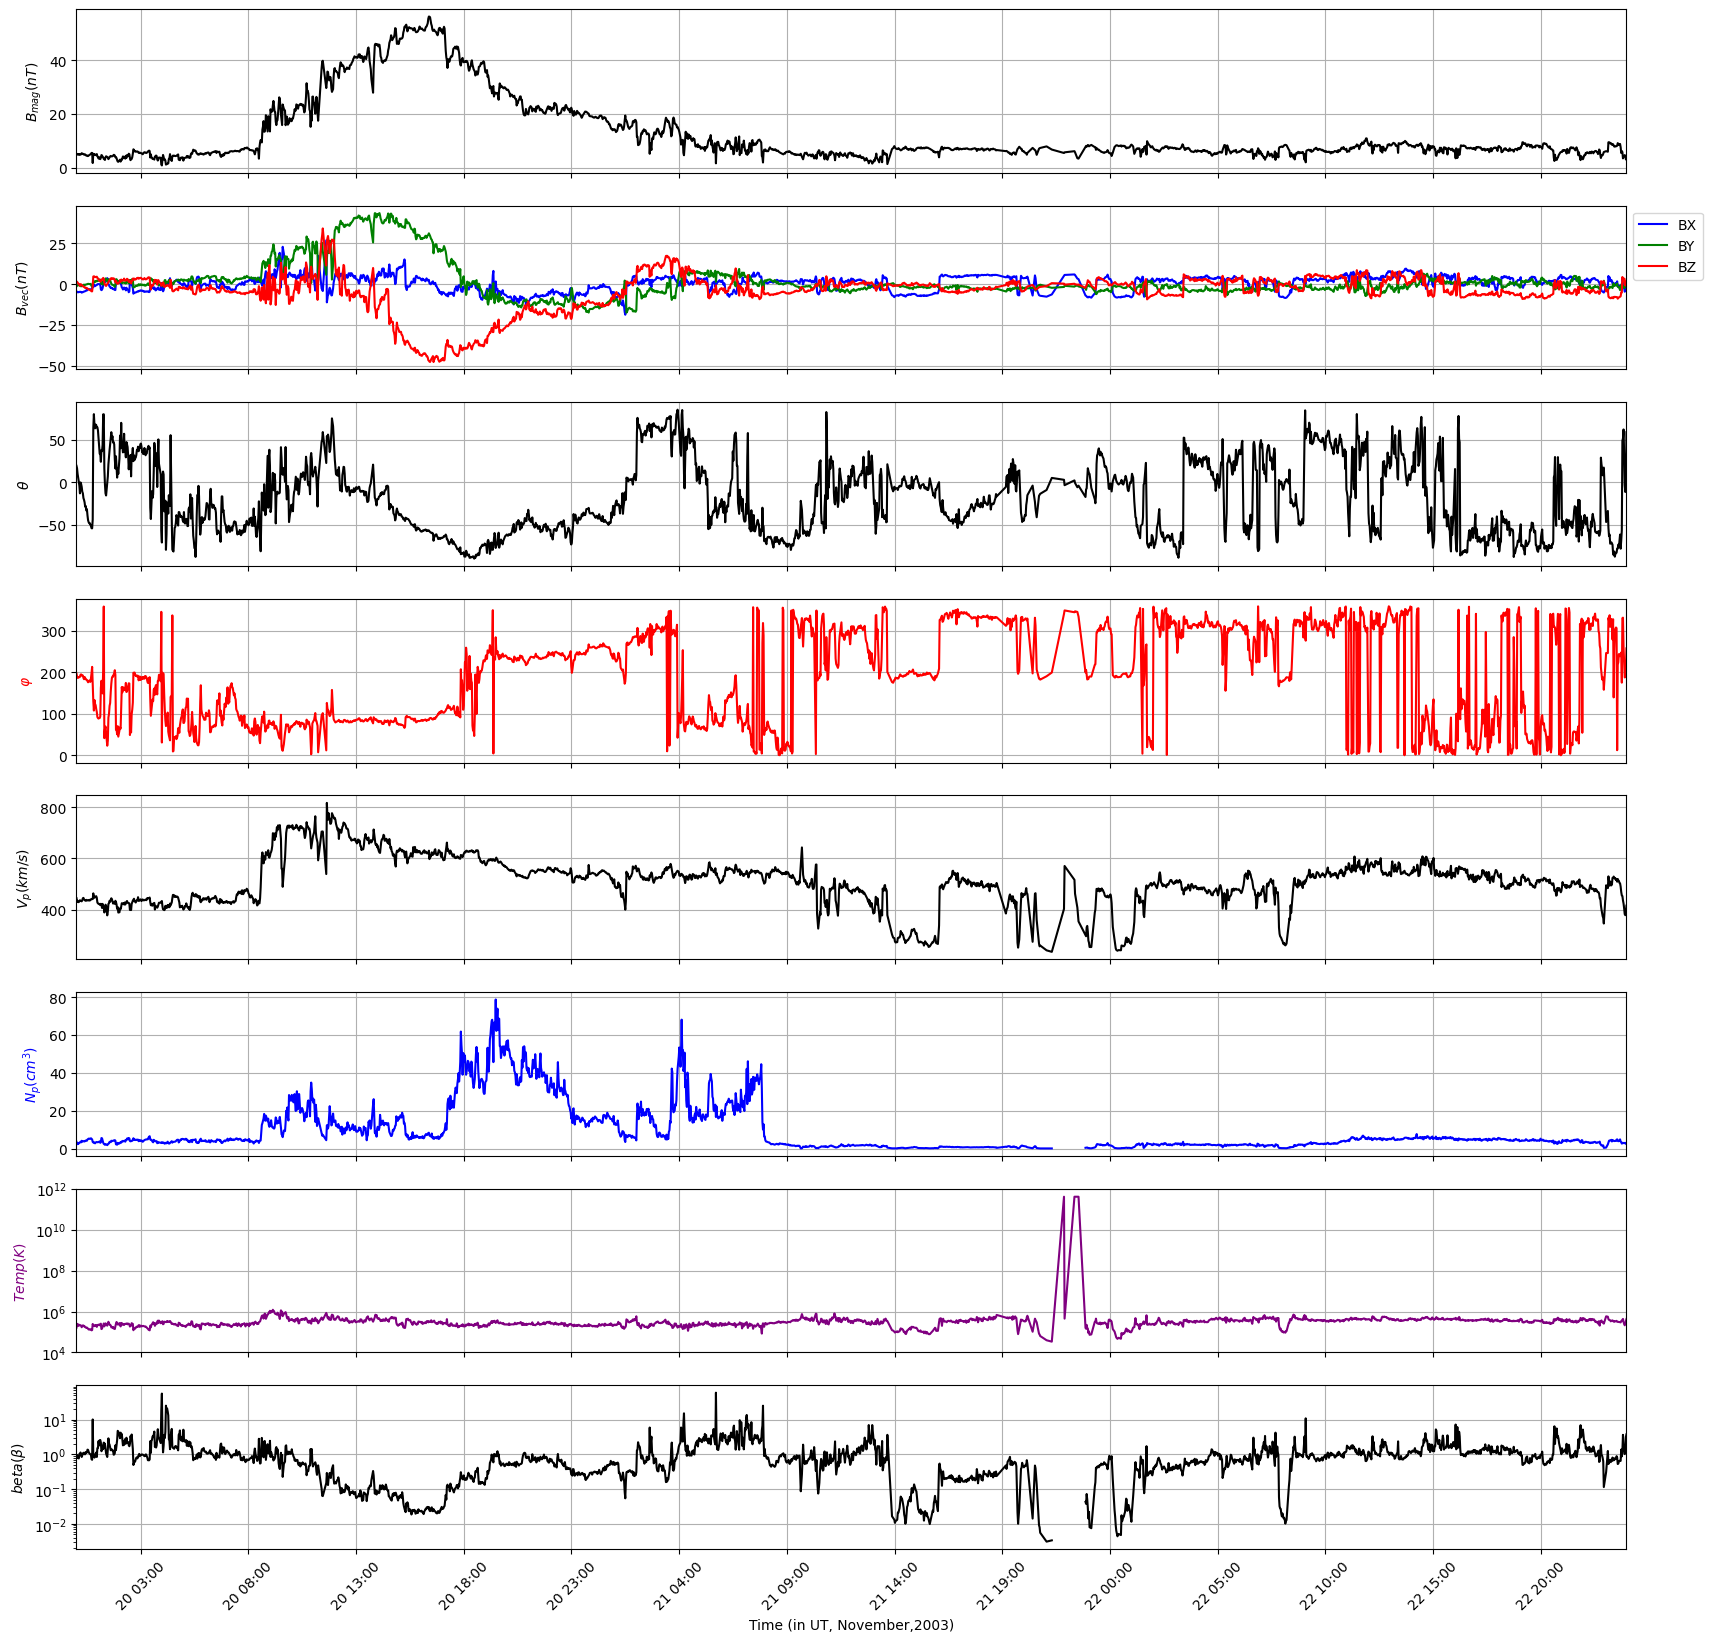

In [14]:
from modules.plotter import Plotting

plot  = Plotting()

plot.ipplot(days_3['t_range'],b_mag,BX,BY,BZ,tehta_angle,phi_angle,vp,p_density,temp,p_beta)
